# Conditional imputer

In this example, we use the popular California housing dataset for regression available at https://www.kaggle.com/datasets/camnugent/california-housing-prices.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import shapiq

shapiq.__version__

'0.0.8'

### load data

In [2]:
X, y = shapiq.load_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.25, random_state=42
)
n_features = X_train.shape[1]

### train a model

In [3]:
model = RandomForestRegressor(
    n_estimators=500, max_depth=n_features, max_features=2 / 3, max_samples=2 / 3, random_state=42
)
model.fit(X_train, y_train)
print("Train R2: {:.4f}".format(model.score(X_train, y_train)))
print("Test  R2: {:.4f}".format(model.score(X_test, y_test)))

Train R2: 0.7990
Test  R2: 0.7462


### conditional imputation for model-agnostic explanatons

We use `shapiq.ConditionalImputer` instead of `shapiq.MarginalImputer` in `shapiq.TabularExplainer` to take into account feature dependence.

It has the following key attributes:
- `sample_size`: The number of samples to draw from the conditional background data for imputation. Defaults to `10`.

- `conditional_budget`: The number of coallitions to sample per each point in `data` for training the generative model. Defaults to `16`.

- `conditional_threshold`: A quantile threshold defining a neighbourhood of samples to draw `sample_size` from. A value between `0.0` and `1.0`. Defaults to `0.05`.

- `random_state`: The random state to use for sampling. Defaults to `None`.

Use `imputer="conditional"` in `shapiq.TabularExplainer` and pass these attributes as `**kwargs`. 

In [4]:
explainer = shapiq.TabularExplainer(
    # attributes of the explainer
    model=model, data=X_train, index="SII", max_order=2,
    # attributes of the imputer
    imputer="conditional", sample_size=100, conditional_budget=32, conditional_threshold=0.04
)

**Note that** the initialization of conditional imputation will take some time, which is different than in case of `imputer="marginal"`.

Next, select an instance to be explained.

In [5]:
x = X_test[100]

Call an `explain()` interface setting `random_state` for reproducible approximation.

In [6]:
interaction_values = explainer.explain(x, random_state=0)
interaction_values

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=2.0699756848160713
)

Visualize the explanation.

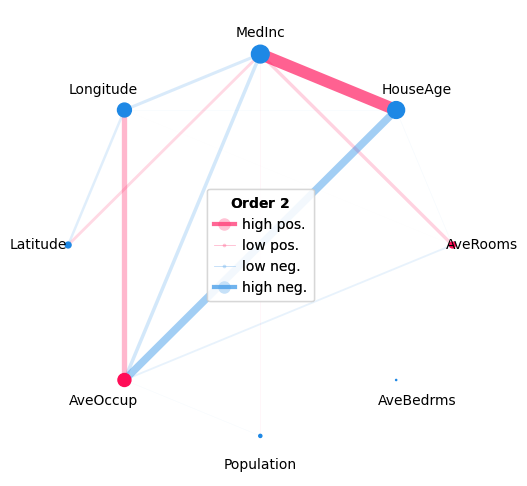

In [7]:
_ = shapiq.network_plot(
    first_order_values=interaction_values.get_n_order_values(1),
    second_order_values=interaction_values.get_n_order_values(2),
    feature_names=X.columns,
)

Increasing the `conditional_budget` will increase the initialization time of `shapiq.ConditionalImputer`, but should yield more accurate approximation of the conditional distribution used for the imputation of missing values.

In [8]:
explainer_longer = shapiq.TabularExplainer(
    # attributes of the explainer
    model=model, data=X_train, index="SII", max_order=2,
    # attributes of the imputer
    imputer="conditional", sample_size=100, conditional_budget=256, conditional_threshold=0.04
)

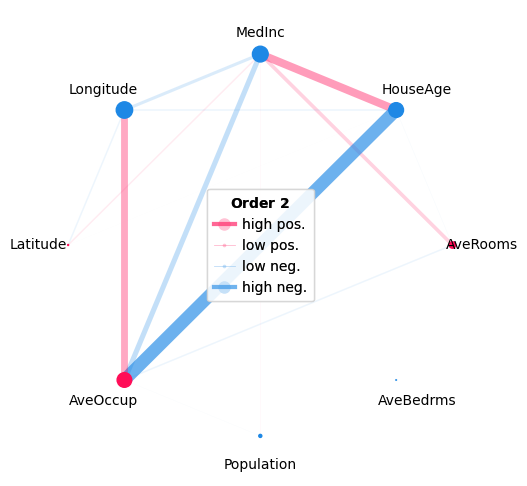

In [9]:
iv_longer = explainer_longer.explain(x, random_state=0)
_ = shapiq.network_plot(
    first_order_values=iv_longer.get_n_order_values(1),
    second_order_values=iv_longer.get_n_order_values(2),
    feature_names=X.columns,
)

Likewise, increasing the `sample_size` will increase the computation time of `explain()`, but should yield a more accurate approximation of the Shapley interactions.

In [10]:
explainer_longer._imputer.sample_size = 500

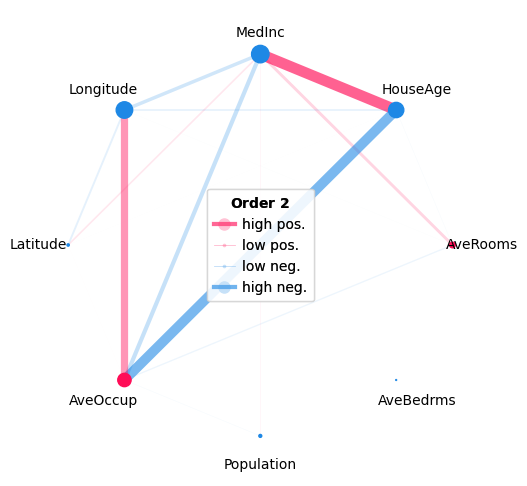

In [11]:
iv_even_longer = explainer_longer.explain(x, random_state=0)
_ = shapiq.network_plot(
    first_order_values=iv_even_longer.get_n_order_values(1),
    second_order_values=iv_even_longer.get_n_order_values(2),
    feature_names=X.columns,
)

#### For details, see API reference of [shapiq.ConditionalImputer](https://shapiq.readthedocs.io/en/latest/api/shapiq.games.html#shapiq.games.ConditionalImputer) 